<a href="https://colab.research.google.com/github/devashish-roy/gated-recurrent-unit-GRU-/blob/main/GRU_GestureAnalysis_AddedFeature_OneLabelPerSequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Implemenataion of GRU for the gesture classification**  

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from google.colab import files


**Prepare the data**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

If re-running start by reading the preprocessed data excel (Go to lower cells).. Because pre-processing takes a lot of time and so prerpocesed data has been saved in excel.

In [ ]:
#data = pd.read_excel('combined_data.xlsx')
data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Advance data mining/combined_data.xlsx')

# Display the first few rows of the sample to understand the structure
data.head()

,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,col_10,...,col_54,col_55,col_56,col_57,col_58,col_59,col_60,action,name,num_times
0,-0.377219,0.676463,2.477132,-0.367249,0.493018,2.566909,-0.529421,0.355840,2.576270,-0.194301,...,2.683695,-0.466046,-0.898524,2.631478,-0.207994,-0.936921,2.647322,afternoon,apurve,1
1,-0.376956,0.676517,2.476770,-0.366931,0.492976,2.566630,-0.529115,0.355951,2.576212,-0.194166,...,2.683765,-0.484327,-0.924024,2.698534,-0.207764,-0.937304,2.633385,afternoon,apurve,1
2,-0.377076,0.676532,2.476376,-0.366147,0.492745,2.566584,-0.528687,0.355584,2.575751,-0.194098,...,2.684294,-0.484638,-0.926029,2.699292,-0.207359,-0.937390,2.639276,afternoon,apurve,1
3,-0.377247,0.675063,2.476167,-0.366134,0.492734,2.566559,-0.528485,0.355650,2.575728,-0.194087,...,2.684332,-0.466230,-0.898756,2.632194,-0.209036,-0.937718,2.646430,afternoon,apurve,1
4,-0.377483,0.674604,2.476354,-0.366084,0.492718,2.566469,-0.528106,0.355623,2.575532,-0.194132,...,2.685030,-0.466177,-0.899217,2.631851,-0.209116,-0.938717,2.646000,afternoon,apurve,1


In [ ]:
print(data.shape)
print(data['action'].unique())
print(data['name'].unique())

(201054, 63)
['afternoon' 'baby' 'big' 'born' 'bye' 'calendar' 'child' 'cloud' 'come'
 'daily' 'dance' 'dark' 'day' 'enjoy' 'go' 'hello' 'home' 'love' 'my'
 'name' 'no' 'rain' 'sorry' 'strong' 'study' 'thankyou' 'welcome' 'wind'
 'yes' 'you']
['apurve' 'gautam' 'mahendra' 'parveen' 'pradeep' 'pramod' 'prateek'
 'rajat' 'rajkumar' 'shewta']


Encode name and action columns.. GRU needs labesl in integers

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the 'action' column
data['action_encoded'] = label_encoder.fit_transform(data['action'])
data['name_encoded'] = label_encoder.fit_transform(data['name'])


# Create a new dataframe with only the coordinate data
preprocessed_data = data.iloc[:, :60].copy()

# Add the encoded columns to the new dataframe
preprocessed_data['action_encoded'] = data['action_encoded']
preprocessed_data['name_encoded'] = data['name_encoded']



# Rename columns
new_column_names = [f'{coord}{i}' for i in range(1, 21) for coord in ['x', 'y', 'z']]
new_column_names.extend(['action_encoded','name_encoded'])
preprocessed_data.columns = new_column_names


# Display the first few rows of the preprocessed data
preprocessed_data.head()


,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,y18,z18,x19,y19,z19,x20,y20,z20,action_encoded,name_encoded
0,-0.377219,0.676463,2.477132,-0.367249,0.493018,2.566909,-0.529421,0.355840,2.576270,-0.194301,...,-0.865148,2.683695,-0.466046,-0.898524,2.631478,-0.207994,-0.936921,2.647322,0,0
1,-0.376956,0.676517,2.476770,-0.366931,0.492976,2.566630,-0.529115,0.355951,2.576212,-0.194166,...,-0.866005,2.683765,-0.484327,-0.924024,2.698534,-0.207764,-0.937304,2.633385,0,0
2,-0.377076,0.676532,2.476376,-0.366147,0.492745,2.566584,-0.528687,0.355584,2.575751,-0.194098,...,-0.866254,2.684294,-0.484638,-0.926029,2.699292,-0.207359,-0.937390,2.639276,0,0
3,-0.377247,0.675063,2.476167,-0.366134,0.492734,2.566559,-0.528485,0.355650,2.575728,-0.194087,...,-0.866281,2.684332,-0.466230,-0.898756,2.632194,-0.209036,-0.937718,2.646430,0,0
4,-0.377483,0.674604,2.476354,-0.366084,0.492718,2.566469,-0.528106,0.355623,2.575532,-0.194132,...,-0.867698,2.685030,-0.466177,-0.899217,2.631851,-0.209116,-0.938717,2.646000,0,0


Add new features. This step takes time so the preprocssed data is saved in excel for later use.

In [ ]:
# Add new features - distance of all points from join 11. This will add 19 features.
for i in range(preprocessed_data.shape[0]):
#for i in range(10):
  for j in range(1,21):
    if j != 11:
       distance = np.sqrt((preprocessed_data.iloc[i][f'x{j}'] - preprocessed_data.iloc[i]['x11'])**2 +
                                                                   (preprocessed_data.iloc[i][f'y{j}'] - preprocessed_data.iloc[i]['y11'])**2 +
                                                                   (preprocessed_data.iloc[i][f'z{j}'] - preprocessed_data.iloc[i]['z11'])**2)
       preprocessed_data.at[i, f'Dist_Join{j}_Join11'] = distance

preprocessed_data.head()

Move the name and the action to the end of the columns

In [ ]:
# List of columns to move to the end
cols_to_move = ['action_encoded', 'name_encoded']

# Get the list of remaining columns
remaining_cols = [col for col in preprocessed_data.columns if col not in cols_to_move]

# Reorder the DataFrame columns: first the remaining columns, then the columns to move
preprocessed_data = preprocessed_data[remaining_cols + cols_to_move]

In [ ]:
preprocessed_data.head()

In [ ]:
# save the data in excel file.. This is saved to the google drive
preprocessed_data.to_excel('/content/drive/My Drive/Colab Notebooks/Advance data mining/preprocessed_data.xlsx', index=False)

Start from here, if re-running.

In [5]:
# the pre-processed data xls
data = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Advance data mining/preprocessed_data.xlsx')

In [6]:
# Remove name column
data = data.drop('name_encoded', axis=1)

In [7]:
# copy the data to preprocessed_data
preprocessed_data = data.copy()

In [8]:
preprocessed_data.head()

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,...,Dist_Join12_Join11,Dist_Join13_Join11,Dist_Join14_Join11,Dist_Join15_Join11,Dist_Join16_Join11,Dist_Join17_Join11,Dist_Join18_Join11,Dist_Join19_Join11,Dist_Join20_Join11,action_encoded
0,-0.377219,0.676463,2.477132,-0.367249,0.493018,2.566909,-0.529421,0.355840,2.576270,-0.194301,...,0.069126,0.167921,0.163710,0.624689,0.643342,1.010795,1.025035,1.053643,1.095640,0
1,-0.376956,0.676517,2.476770,-0.366931,0.492976,2.566630,-0.529115,0.355951,2.576212,-0.194166,...,0.069121,0.167936,0.163626,0.627602,0.643787,1.009125,1.025950,1.086551,1.095242,0
2,-0.377076,0.676532,2.476376,-0.366147,0.492745,2.566584,-0.528687,0.355584,2.575751,-0.194098,...,0.069094,0.168020,0.163437,0.627432,0.643676,1.011083,1.026146,1.088640,1.095566,0
3,-0.377247,0.675063,2.476167,-0.366134,0.492734,2.566559,-0.528485,0.355650,2.575728,-0.194087,...,0.069098,0.168040,0.163392,0.627361,0.642746,1.011197,1.026174,1.053923,1.096096,0
4,-0.377483,0.674604,2.476354,-0.366084,0.492718,2.566469,-0.528106,0.355623,2.575532,-0.194132,...,0.069101,0.168014,0.163327,0.627155,0.643051,1.011589,1.027694,1.054333,1.097016,0


Split the data in Train (70%), validation(15%) and test(15%) set

In [9]:
# Splitting Dataset into training, validation and testing sets
from sklearn.model_selection import train_test_split
X = preprocessed_data.iloc[:, :-1]
y = preprocessed_data.iloc[:, -1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y) # Should not use shuffle=True as we will loose the temporal information in the toime series data
                                                                                                     # However to get the good spread of labels between train and test, use stratify = y
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42,shuffle=False)


print(X_train.shape, X_test.shape, X_val.shape)

print(y_train.shape, y_test.shape, y_val.shape)

(140737, 79) (30158, 79) (30159, 79)
(140737, 1) (30158, 1) (30159, 1)


In [38]:
# Print types to verify
print(type(X))  # Should be <class 'pandas.core.frame.DataFrame'>
print(type(y))  # Should be <class 'pandas.core.frame.DataFrame'>

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [37]:
# Print types to verify
print(type(X_train))  # Should be <class 'pandas.core.frame.DataFrame'>
print(type(y_train))  # Should be <class 'pandas.core.frame.DataFrame'>

<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>


In [36]:
y.describe()

,action_encoded
count,201054.000000
mean,14.277314
std,8.637347
min,0.000000
25%,7.000000
50%,14.000000
75%,22.000000
max,29.000000


Normalise the data

In [10]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
X_train

array([[0.10872339, 0.46836816, 0.62495789, ..., 0.27508178, 0.44814919,
        0.34182538],
       [0.40416339, 0.68069644, 0.6595241 , ..., 0.41502616, 0.65857001,
        0.51249483],
       [0.58278039, 0.53529359, 0.34242867, ..., 0.35611346, 0.55367042,
        0.41973812],
       ...,
       [0.48661945, 0.53567732, 0.22114891, ..., 0.35588458, 0.4767954 ,
        0.43403779],
       [0.3207362 , 0.61609575, 0.67416212, ..., 0.33017452, 0.57111194,
        0.35819485],
       [0.4212638 , 0.60557459, 0.67484357, ..., 0.36730344, 0.61463284,
        0.46543333]])

In [ ]:
y_train.shape

(140737, 1)

In [23]:
y_train.head()

,action_encoded
114632,16
18630,2
37797,5
68971,10
125796,18


In [11]:
# Define sequence length (e.g., 10 time steps per sequence)
sequence_length = 10

# Function to create sequences of data for GRU
def create_sequences(x, y, sequence_length):
    sequences = []
    labels = []
    #print(len(x))
    #print(len(y))
    for i in range(len(x) - sequence_length - 1):
        # Debugging: Print current index range
        #print(f"Creating sequence from index {i} to {i + sequence_length - 1}")

        # Create a sequence of `sequence_length` time steps
        sequences.append(x[i:i + sequence_length])

        # Take the corresponding label from the last time step of the sequence
        last_time_step_of_seq = i + sequence_length - 1
        labels.append(y.iloc[last_time_step_of_seq,0])

    return np.array(sequences), np.array(labels)

# Apply the function to your dataset
X_train_sequences, y_train_sequences = create_sequences(X_train, y_train, sequence_length)
X_test_sequences, y_test_sequences = create_sequences(X_test, y_test, sequence_length)
X_val_sequences, y_val_sequences = create_sequences(X_val, y_val, sequence_length)

# Print shapes to verify
print(f"X_train_sequences shape: {X_train_sequences.shape}")  # Should be (num_sequences, sequence_length, input_size), (140727, 10, 79)
print(f"y_train_sequences shape: {y_train_sequences.shape}")  # Should be (num_sequences, 1), (140727, 10, 1)
print(f"X_test_sequences shape: {X_test_sequences.shape}")
print(f"y_test_sequences shape: {y_test_sequences.shape}")
print(f"X_val_sequences shape: {X_val_sequences.shape}")
print(f"y_val_sequences shape: {y_val_sequences.shape}")
#print(X_train_sequences[0])
#print(y_train_sequences[0])

X_train_sequences shape: (140726, 10, 79)
y_train_sequences shape: (140726,)
X_test_sequences shape: (30147, 10, 79)
y_test_sequences shape: (30147,)
X_val_sequences shape: (30148, 10, 79)
y_val_sequences shape: (30148,)


**Implementation of GRU**

In [12]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()
        self.hidden_size = hidden_size

        # Weights for the update gate
        self.W_z = nn.Linear(input_size, hidden_size)
        self.U_z = nn.Linear(hidden_size, hidden_size)

        # Weights for the reset gate
        self.W_r = nn.Linear(input_size, hidden_size)
        self.U_r = nn.Linear(hidden_size, hidden_size)

        # Weights for the candidate hidden state
        self.W_h = nn.Linear(input_size, hidden_size)
        self.U_h = nn.Linear(hidden_size, hidden_size)

    def forward(self, x, h_prev):
        # Update gate
        z_t = torch.sigmoid(self.W_z(x) + self.U_z(h_prev))

        # Reset gate
        r_t = torch.sigmoid(self.W_r(x) + self.U_r(h_prev))

        # Candidate hidden state
        h_tilde = torch.tanh(self.W_h(x) + r_t * self.U_h(h_prev))

        # New hidden state
        h_t = (1 - z_t) * h_prev + z_t * h_tilde

        return h_t


In [18]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(GRUNet, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Stack multiple GRU cells for multi-layer GRU
        self.gru_cells = nn.ModuleList([GRUCell(input_size, hidden_size)] +
                                       [GRUCell(hidden_size, hidden_size) for _ in range(num_layers - 1)])

        # Fully connected layer for classification output (output_size = number of classes)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_length, input_size = x.size()

        # Initialize hidden states for each layer
        h_t = [torch.zeros(batch_size, self.hidden_size).to(x.device) for _ in range(self.num_layers)]

        # Store outputs for every time step
        outputs = []

        # Process each time step
        for t in range(seq_length):
            x_t = x[:, t, :] # shape (batch_size, input_size (i.e. 64,79))..For all the sequences(64) in the batch, get all the features (79) at 't' timestep
            for i in range(self.num_layers):
                h_t[i] = self.gru_cells[i](x_t, h_t[i])
                x_t = h_t[i]  # Output of one layer is the input to the next layer


        # Output layer using the hidden state from the last layer. After processing all time steps, use the last hidden state for output
        out = self.fc(h_t[-1])  # No softmax here; it will be handled by the loss function

        return out


Train and Test with gesture analysis data

In [19]:
#from itertools import count
# Hyperparameters
input_size = len(preprocessed_data.columns) - 1                       # Number of features in the input - 79
hidden_size = 128                                                     # Number of hidden units in each GRU cell
num_layers = 2                                                        # Number of GRU layers
output_size = len(preprocessed_data['action_encoded'].unique())       # Number of classes for classification - 30
learning_rate = 0.001

# Initialize the model, criterion, and optimizer
model = GRUNet(input_size, hidden_size, output_size, num_layers)
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


In [15]:
# Example training loop
num_epochs = 10
batch_size = 64

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.long)
x_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_sequences, dtype=torch.long)
x_val_tensor = torch.tensor(X_val_sequences, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_sequences, dtype=torch.long)

# Create a DataLoader for batching
train_data = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
test_data = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
val_data = torch.utils.data.TensorDataset(x_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)

Train and validate the model

Epoch [1/10], Training Loss: 1.1077, Validation Loss: 0.9122, Training Accuracy: 61.60%, Validation Accuracy: 68.36%
Epoch [2/10], Training Loss: 0.7916, Validation Loss: 0.6560, Training Accuracy: 73.00%, Validation Accuracy: 78.39%
Epoch [3/10], Training Loss: 0.6003, Validation Loss: 0.5255, Training Accuracy: 80.07%, Validation Accuracy: 83.22%
Epoch [4/10], Training Loss: 0.4766, Validation Loss: 0.4410, Training Accuracy: 84.64%, Validation Accuracy: 86.10%
Epoch [5/10], Training Loss: 0.3902, Validation Loss: 0.3745, Training Accuracy: 87.63%, Validation Accuracy: 88.10%
Epoch [6/10], Training Loss: 0.3256, Validation Loss: 0.3133, Training Accuracy: 89.83%, Validation Accuracy: 90.24%
Epoch [7/10], Training Loss: 0.2759, Validation Loss: 0.2725, Training Accuracy: 91.47%, Validation Accuracy: 91.41%
Epoch [8/10], Training Loss: 0.2363, Validation Loss: 0.2382, Training Accuracy: 92.77%, Validation Accuracy: 92.43%
Epoch [9/10], Training Loss: 0.2046, Validation Loss: 0.2234, Tr

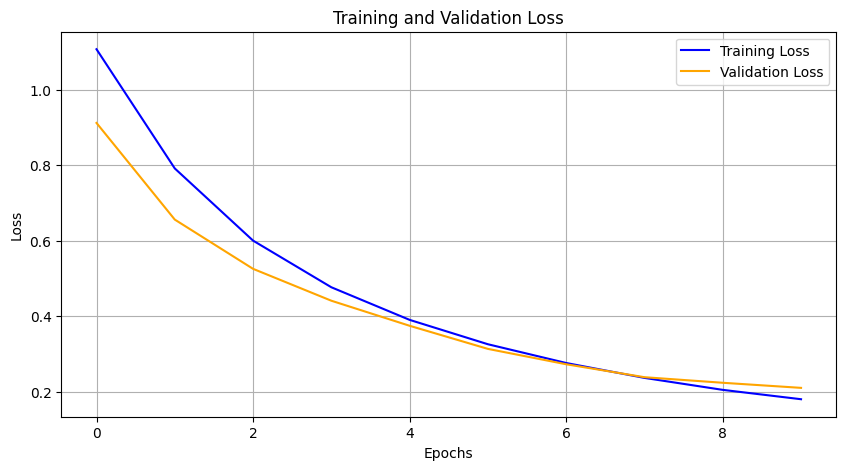

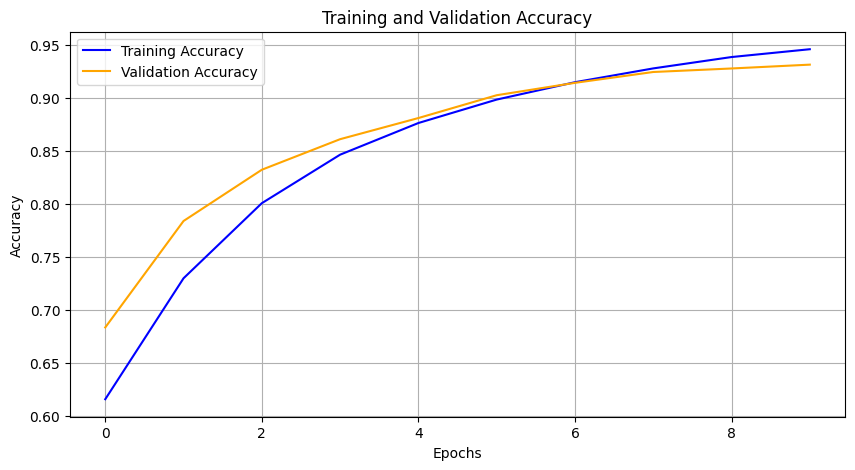

In [21]:
# Lists to store the loss values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for train_x, train_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        train_outputs = model(train_x)  # Shape: (batch_size, sequence_length, output_size)

        _, train_predicted = torch.max(train_outputs, dim=-1)  # Get predicted labels (shape: batch_size, sequence_length)

        # Prepare for calculating accuracy
        train_total += train_y.size(0)
        train_correct += (train_predicted == train_y).sum().item()

        # Reshape output for loss calculation
        # CrossEntropyLoss expects (batch_size * sequence_length, output_size)
        # Targets should be (batch_size * sequence_length)
        train_loss = criterion(train_outputs.view(-1, output_size), train_y.view(-1))

        # Backward pass and optimization
        train_loss.backward()
        optimizer.step()

        # collect losses
        train_running_loss += train_loss.item()

    # Average loss for the epoch
    avg_train_loss = train_running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Training accuracy per epoch
    train_accuracy = train_correct / train_total
    train_accuracies.append(train_accuracy)

#   Model evaluation using validation data set
    model.eval()  # Set model to evaluation mode
    val_running_loss = 0.0
    val_outputs = None
    val_targets = None

    with torch.no_grad():  # Disable gradient calculations for inference
        val_correct = 0
        val_total = 0

        for val_x, val_y in val_loader:
            val_outputs = model(val_x) # val_outputs (shape: Batch size, Output size) (64, 30)
            _, predicted = torch.max(val_outputs, dim=-1)  # Get predicted labels (shape: batch_size, 1)

            val_loss = criterion(val_outputs.view(-1, output_size), val_y.view(-1))  # Calculate validation loss
            val_running_loss += val_loss.item()

            # Prepare for calculating accuracy
            val_total += val_y.size(0)  # Shape (64)
            val_correct += (predicted == val_y).sum().item()


        # Average validation loss
        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # validation accuracy per epoch
        val_accuracy = val_correct / val_total
        val_accuracies.append(val_accuracy)
        #print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

    # Print training and validation loss for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}'f', Training Accuracy: {train_accuracy * 100:.2f}%' f', Validation Accuracy: {val_accuracy * 100:.2f}%')

# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# Plotting the training and validation accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [22]:
# Save the model
model_path = '/content/drive/My Drive/Colab Notebooks/Advance data mining/GRU_GestureAnalysis_AddedFeature_OneLabelPerSequence_model.pth'  #path
torch.save(model.state_dict(), model_path)


Test the model using test set

In [23]:
# Load the model
model_path = '/content/drive/My Drive/Colab Notebooks/Advance data mining/GRU_GestureAnalysis_AddedFeature_OneLabelPerSequence_model.pth'  #path
model = GRUNet(input_size, hidden_size, output_size, num_layers) # Reinitialize the model
model.load_state_dict(torch.load(model_path, weights_only=True))
model.eval()  # Set the model to evaluation mode after loading
print(f'Model loaded from {model_path}')


# Initialize variables to calculate accuracy
test_correct = 0
test_total = 0

# Disable gradient calculation for inference
with torch.no_grad():
    for test_x, test_y in test_loader:  # Assuming you have a test_loader
        # Forward pass through the model
        test_outputs = model(test_x)  # Shape: (batch_size, seq_length, num_classes)

        # Get the indices of the max logit values along the last dimension (num_classes)
        _, predicted_indices = torch.max(test_outputs, dim=-1)  # Shape: (batch_size, seq_length)

        # Calculate total counts
        test_total += test_y.numel()  # Total number of labels in the test set
        test_correct += (predicted_indices == test_y).sum().item()  # Compare predictions with true labels

# Calculate accuracy
test_accuracy = test_correct / test_total
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Model loaded from /content/drive/My Drive/Colab Notebooks/Advance data mining/GRU_GestureAnalysis_AddedFeature_OneLabelPerSequence_model.pth
Test Accuracy: 93.11%
